In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactiveity = 'all'

import numpy as np
import pandas as pd
import torch
import yfinance as yf
from scipy.fftpack import fft, ifft, fftfreq
from scipy.interpolate import make_interp_spline
from scipy import stats
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm


from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
class Fourier:
    
    def __init__(self, name, start):
        self.name = name
        self.start = start
        self.raw_data = None
        self.ret_monthly = None
        self.ret_mean = None
        self.cycle_data = None
        self.pred_ret_monthly = []
        self.best_T = []
        self.sin_params1 = []
        self.sin_params2 = []
        
    def _get_raw_data(self):
        self.raw_data = yf.download(self.name, start=self.start)
        
    def _adf(self, data, col, lag=None):
        result = ts.adfuller(data[col], lag)
        return (self.name + ' ' + col + "_ADF-test", result)
    
    def _qq_plot(self, data, col):
        plt.figure(figsize=(10, 10))
#         plt.title("{}_Q_Q_plot".format(self.name))
#         stats.probplot(data[col], dist='norm', plot=plt)
        data = data[[col]]
        data['Quantile'] = data[col].rank(pct=True, ascending=True)
        ax = sns.regplot(x=data[col], y=data['Quantile'], ci=None, color='b',line_kws={'color': 'r'})
        ax.set_title("{}_{}_Q_Q_plot".format(self.name, col))
        
    def _calculate_ret(self):
        price = self.raw_data.copy()[['Adj Close']]
        price.index = pd.to_datetime(price.index)
        price = price.resample('M').last()
        ret_12 = (price / price.shift(12) - 1).dropna()
        ret_12.columns = ['ret']
        self.ret_mean = ret_12.mean()[0]
        self.ret_monthly = ret_12 - self.ret_mean
        
    def _plot_monthly_ret(self, width=30, height=10):
        plt.figure(figsize=(width, height))
        plt.title("{}_yoy_demean_ret".format(self.name))
        plt.plot(self.ret_monthly)
    
    def _fourier_transform(self):
        x = np.array(self.ret_monthly.index)
        y = np.array(self.ret_monthly['ret'])
        y = np.concatenate((y, np.zeros(12 * len(y))),axis=0)
        # 数据长度
        N = len(y)
        # 采样频率
        fs = 1
        y_f = fft(y)
        # x_f = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
        x_f = fftfreq(N, 1 / fs)[:N // 2]
        df = pd.DataFrame(2.0 / N * np.abs(y_f[: N // 2]), columns=['A'], index=x_f)
        df['T'] = 1 / df.index
        df.set_index('T', inplace=True)
        self.cycle_data = df.iloc[:0:-1]
        self.cycle_data.iloc[-1, 0] = 0
        
    def _plot_spec(self, width=30, height=10):
        max_ = pd.DataFrame([], columns=['A'])
        for i in range(1, len(self.cycle_data) - 1):
            if self.cycle_data.iloc[i, 0] > self.cycle_data.iloc[i - 1, 0] and \
                self.cycle_data.iloc[i, 0] > self.cycle_data.iloc[i + 1, 0]:
                max_.loc[self.cycle_data.index[i]] = self.cycle_data.iloc[i, 0]
        max_.sort_values(by=['A'], ascending=False, inplace=True)

        plt.figure(figsize=(width, height))
        plt.title("{}_Spectrogram".format(self.name))
        self.best_T.append(round(max_.index[0], 1))
        self.best_T.append(round(max_.index[1], 1))

        # 标点
        plt.scatter(max_.index[0], max_.iloc[0, 0], s=25, c='r')
        plt.text(max_.index[0], max_.iloc[0, 0], "({}, {})".format(str(round(max_.index[0], 1)), str(round(max_.iloc[0, 0], 4))), ha='center', va='bottom', fontsize=10)
        plt.scatter(max_.index[1], max_.iloc[1, 0], s=25, c='r')
        plt.text(max_.index[1], max_.iloc[1, 0], "({}, {})".format(str(round(max_.index[1], 1)), str(round(max_.iloc[1, 0], 4))), ha='center', va='bottom', fontsize=10)
        plt.plot(self.cycle_data.iloc[:len(self.cycle_data) - 10])
        
    def _filter(self, T=42.9, width=20, height=10):
        t = np.arange(len(self.ret_monthly))
        T1 = T
        A1 = 0.3
        Phi1 = 0.1
        y = A1 * np.sin(2 * np.pi / T1 * t + Phi1)
        lr = 0.005
        cnt = 0
        ret_np = np.array(self.ret_monthly['ret'])

        while(True):
            cnt += 1
            cost_A1 = ((y - ret_np) * np.sin(2 * np.pi / T1 * t + Phi1)).sum()
            cost_Phi1 = ((y - ret_np) * np.cos(2 * np.pi / T1 * t + Phi1)).sum()
            A1 = A1 - lr * cost_A1
            Phi1 = Phi1 - lr * cost_Phi1
            y = A1 * np.sin(2 * np.pi / T1 * t + Phi1)
            if cnt == 50:
                break
        plt.figure(figsize=(width, height))
        plt.title("{}_{}M_Filter".format(self.name, T))
        plt.plot(y)
        plt.plot(ret_np)
        print("\nPhi: {}, A: {}, T: {}".format(Phi1, A1, T1))
        self.sin_params1.append((Phi1, A1, T1))
        self.pred_ret_monthly.append(y)
        
    def _filter_2(self, T1=42.9, T2=93, width=20, height=10):
        t = np.arange(len(self.ret_monthly))
        A1 = 0.1
        A2= 0.1
        Phi1 = 0.1
        Phi2 = 0.1
        y = A1 * np.sin(2 * np.pi / T1 * t + Phi1) + A2 * np.sin(2 * np.pi / T2 * t + Phi2)
        lr = 0.005
        cnt = 0
        ret_np = np.array(self.ret_monthly['ret'])

        while(True):
            cnt += 1
            cost_A1 = ((y - ret_np) * np.sin(2 * np.pi / T1 * t + Phi1)).sum()
            cost_A2 = ((y - ret_np) * np.sin(2 * np.pi / T2 * t + Phi2)).sum()
            cost_Phi1 = ((y - ret_np) * np.cos(2 * np.pi / T1 * t + Phi1)).sum()
            cost_Phi2 = ((y - ret_np) * np.cos(2 * np.pi / T2 * t + Phi2)).sum()
            A1 = A1 - lr * cost_A1
            A2 = A2 - lr * cost_A2
            Phi1 = Phi1 - lr * cost_Phi1
            Phi2 = Phi2 - lr * cost_Phi2
            y = A1 * np.sin(2 * np.pi / T1 * t + Phi1) + A2 * np.sin(2 * np.pi / T2 * t + Phi2)
            if cnt == 1000:
                break
        
        new_t = np.arange(int(1.1 * len(self.ret_monthly)))
        new_y = A1 * np.sin(2 * np.pi / T1 * new_t + Phi1) + A2 * np.sin(2 * np.pi / T2 * new_t + Phi2)
        
        plt.figure(figsize=(width, height))
        plt.title("{}_{}M & {}M_Filter".format(self.name, T1, T2))
        plt.plot(y)
        plt.plot(ret_np)
        print("\nPhi1: {}, A1: {}, T1: {},\n Phi2: {}, A2: {}, T2: {}".format(Phi1, A1, T1, Phi2, A2, T2))
                          
        plt.figure(figsize=(width, height))
        plt.title("{}_{}M & {}M_with_prediction".format(self.name, T1, T2))
        plt.plot(new_y)
        plt.plot(ret_np)
        self.sin_params2.append(((Phi1, A1, T1), (Phi2, A2, T2)))
        self.pred_ret_monthly.append(y)
        
    @staticmethod
    def _linear_regression(X, y):
        model = sm.OLS(y, X)
        results = model.fit()
        print()
        print(results.summary())
        
    def _stats_pipeline(self):
        self._get_raw_data()
        self._calculate_ret()
        print(self._adf(self.raw_data, 'Adj Close'))
        print(self._adf(self.ret_monthly, 'ret'))
        self._qq_plot(self.raw_data, 'Adj Close')
        self._qq_plot(self.ret_monthly, 'ret')
        
    def _cycle_pipeline(self):
        self._plot_monthly_ret()
        self._fourier_transform()
        self._plot_spec()
        self._filter(T=self.best_T[0])
        self._linear_regression(X=self.pred_ret_monthly[-1], y=np.array(self.ret_monthly['ret']))
        self._filter(T=self.best_T[1])
        self._linear_regression(X=self.pred_ret_monthly[-1], y=np.array(self.ret_monthly['ret']))
        self._filter_2(T1=self.best_T[0], T2=self.best_T[1])
        self._linear_regression(X=self.pred_ret_monthly[-1], y=np.array(self.ret_monthly['ret']))
        
    def _start(self):
        print('\n\n----------', self.name, '----------')


In [3]:
class Multi_Fourier_Comparison:
    
    def __init__(self, names):
        self.Fouriers = [Fourier(name, '1988-01-01') for name in names]
    
    def _plot(self):
        for f in self.Fouriers:
            f._start()
            f._stats_pipeline()
            f._cycle_pipeline()
            
        plt.figure(figsize=(20, 10))
        plt.title("Spectrograms Comparison")
        for f in self.Fouriers:
            f.cycle_data.columns = [f.name]
            max_ = pd.DataFrame([], columns=[f.name])
            for i in range(1, len(f.cycle_data) - 1):
                if f.cycle_data.iloc[i, 0] > f.cycle_data.iloc[i - 1, 0] and \
                    f.cycle_data.iloc[i, 0] > f.cycle_data.iloc[i + 1, 0]:
                    max_.loc[f.cycle_data.index[i]] = f.cycle_data.iloc[i, 0]
            max_.sort_values(by=[f.name], ascending=False, inplace=True)

            # 标点
            plt.scatter(max_.index[0], max_.iloc[0, 0], s=25, c='r')
            plt.text(max_.index[0], max_.iloc[0, 0], "({}, {})".format(str(round(max_.index[0], 1)), str(round(max_.iloc[0, 0], 4))), ha='center', va='bottom', fontsize=10)
            plt.scatter(max_.index[1], max_.iloc[1, 0], s=25, c='r')
            plt.text(max_.index[1], max_.iloc[1, 0], "({}, {})".format(str(round(max_.index[1], 1)), str(round(max_.iloc[1, 0], 4))), ha='center', va='bottom', fontsize=10)
            plt.plot(f.cycle_data.iloc[:len(f.cycle_data) - 10], label=f.name)
        plt.legend()



---------- ^RUA ----------
[*********************100%***********************]  1 of 1 completed
('^RUA Adj Close_ADF-test', (2.676163245879394, 0.9990853882189517, 36, 8526, {'1%': -3.431117214390574, '5%': -2.8618790566677754, '10%': -2.5669504749545884}, 64148.06083014961))
('^RUA ret_ADF-test', (-3.6694010611614263, 0.004564731775184017, 15, 382, {'1%': -3.4475850438570115, '5%': -2.869135963767125, '10%': -2.5708164748773332}, -1083.0580456406203))

Phi: 1.0770068801945996, A: 0.10295877836192709, T: 42.8

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.211
Model:                            OLS   Adj. R-squared (uncentered):              0.209
Method:                 Least Squares   F-statistic:                              106.1
Date:                Fri, 04 Feb 2022   Prob (F-statistic):                    3.29e-22
Time:                        13:45:04   Lo

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


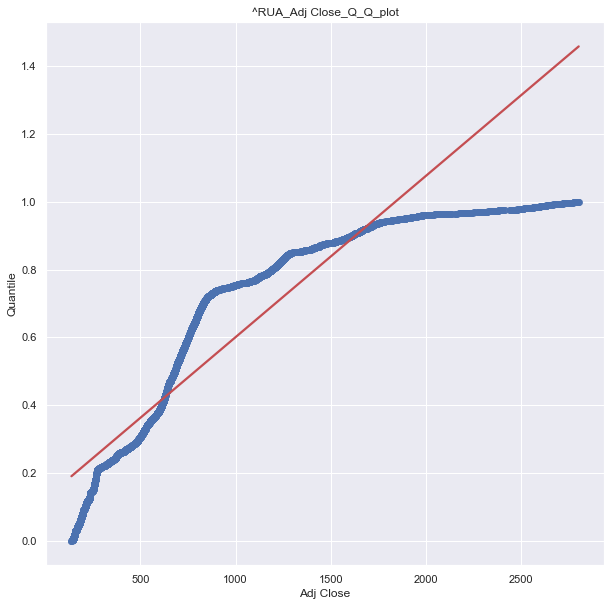

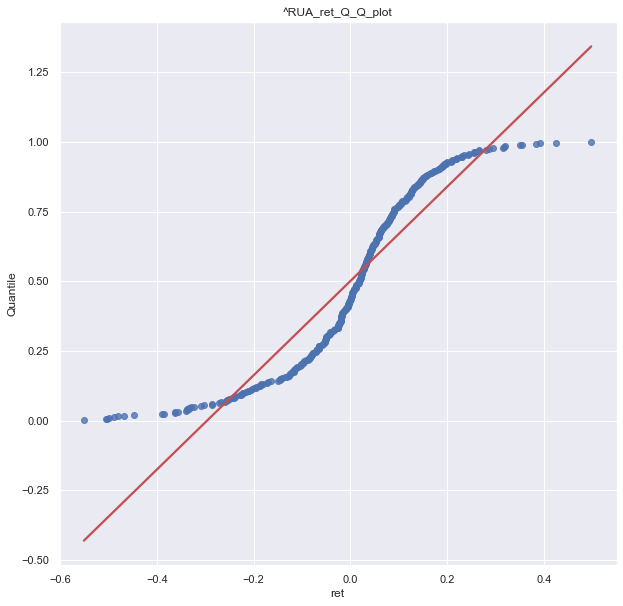

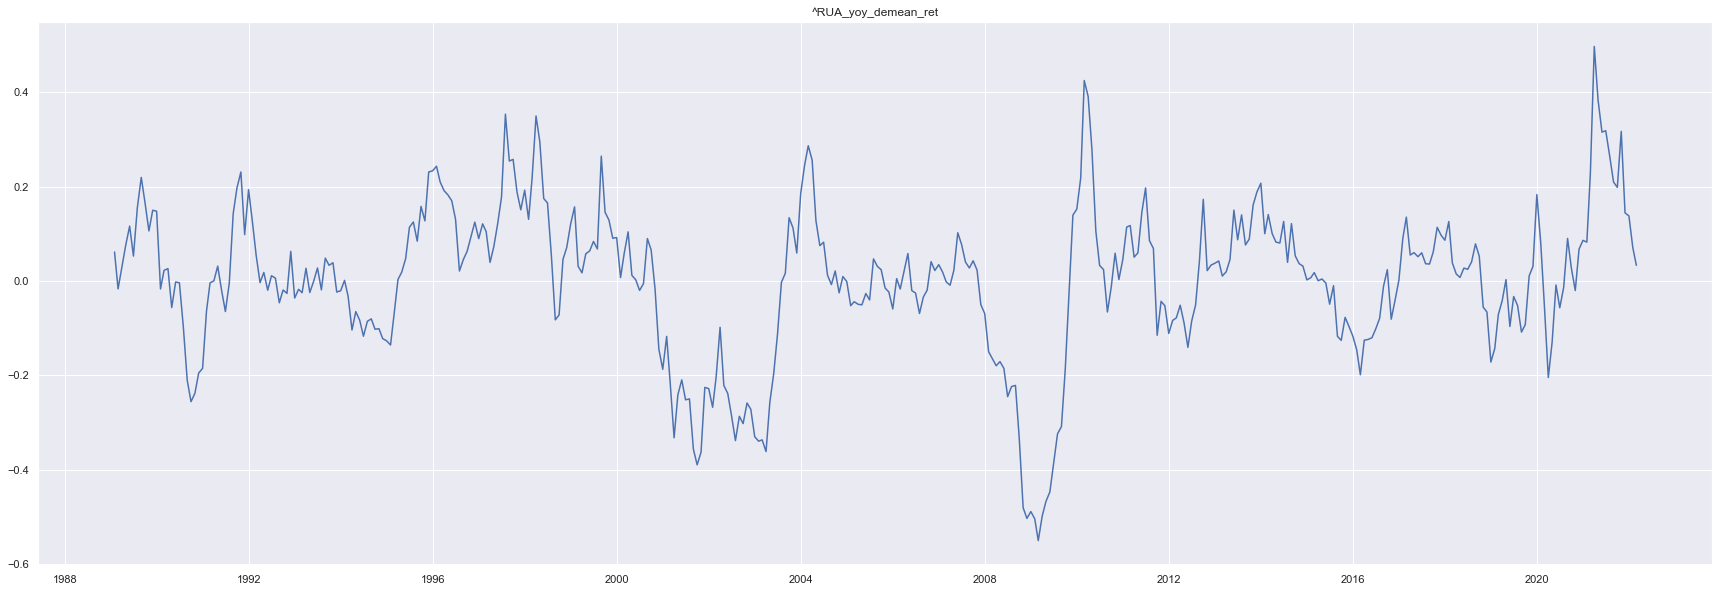

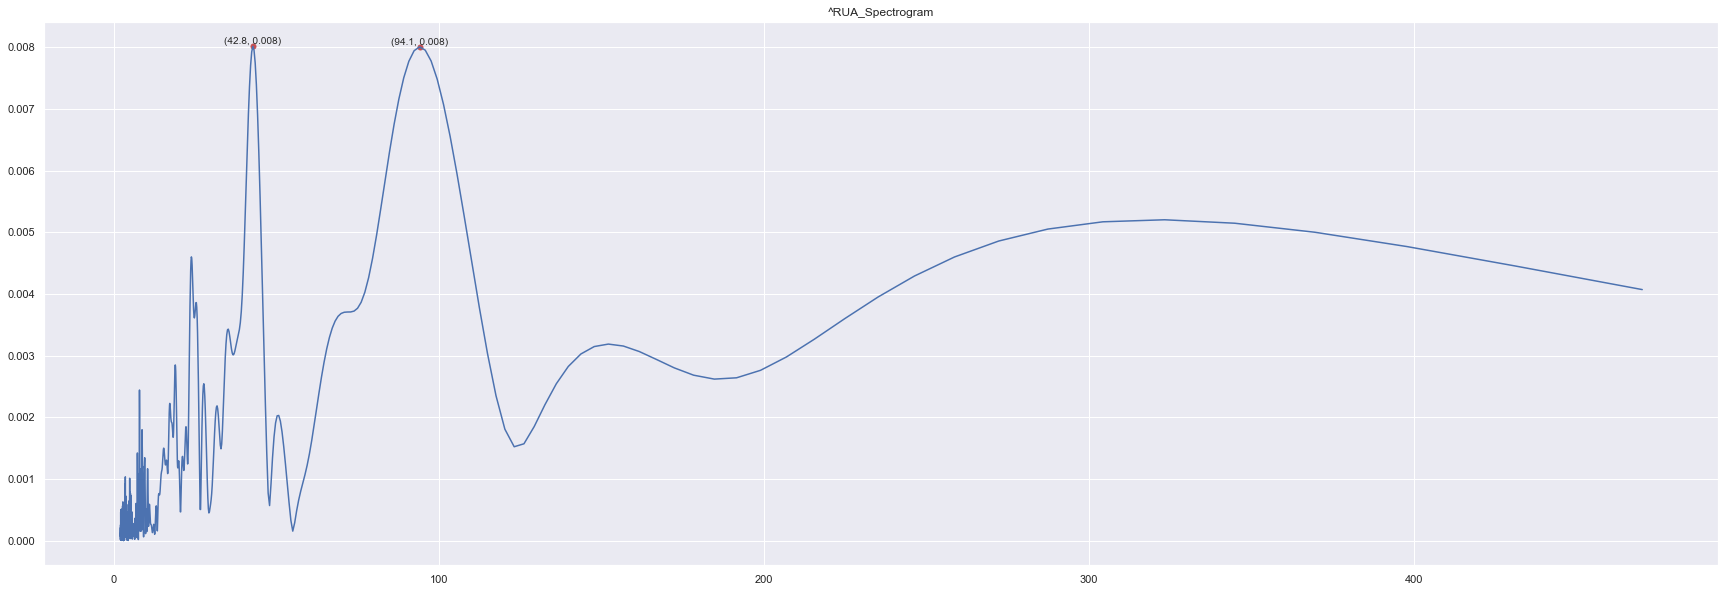

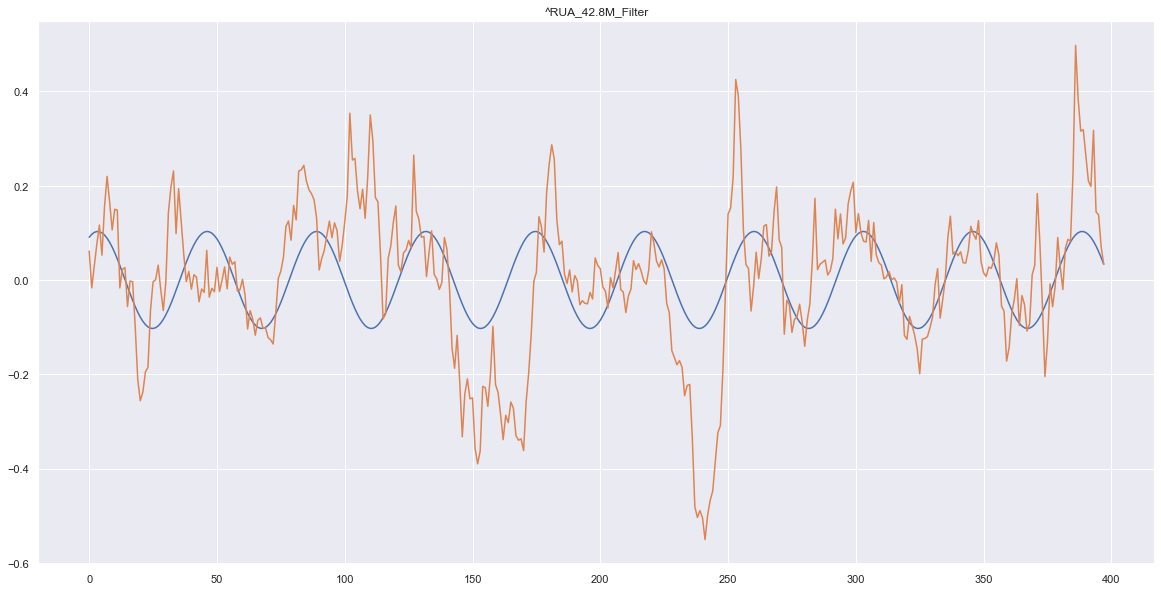

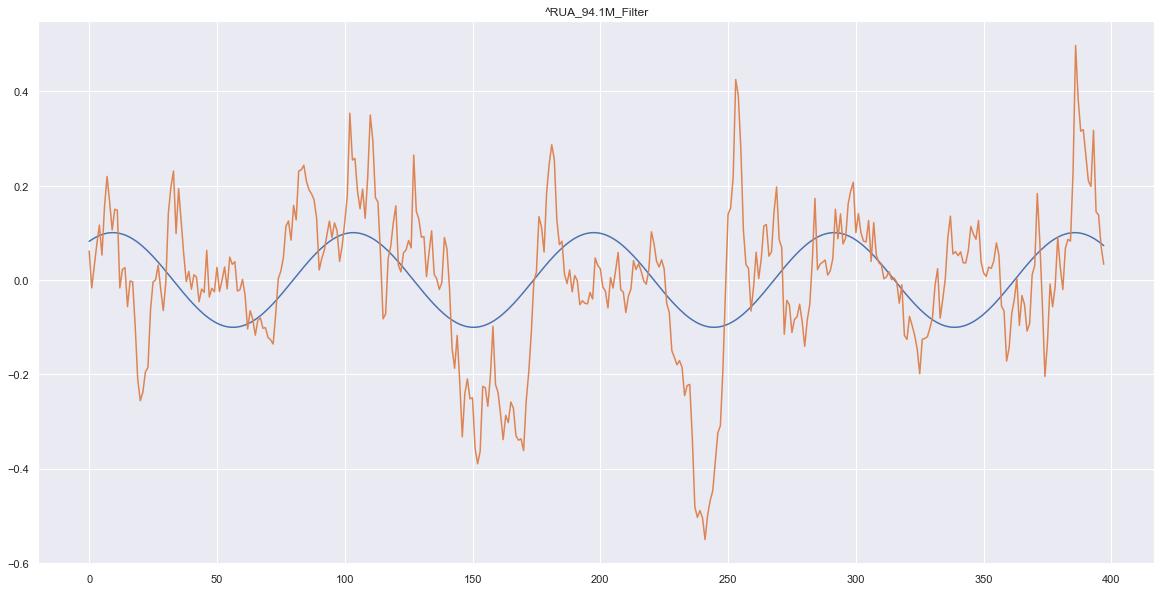

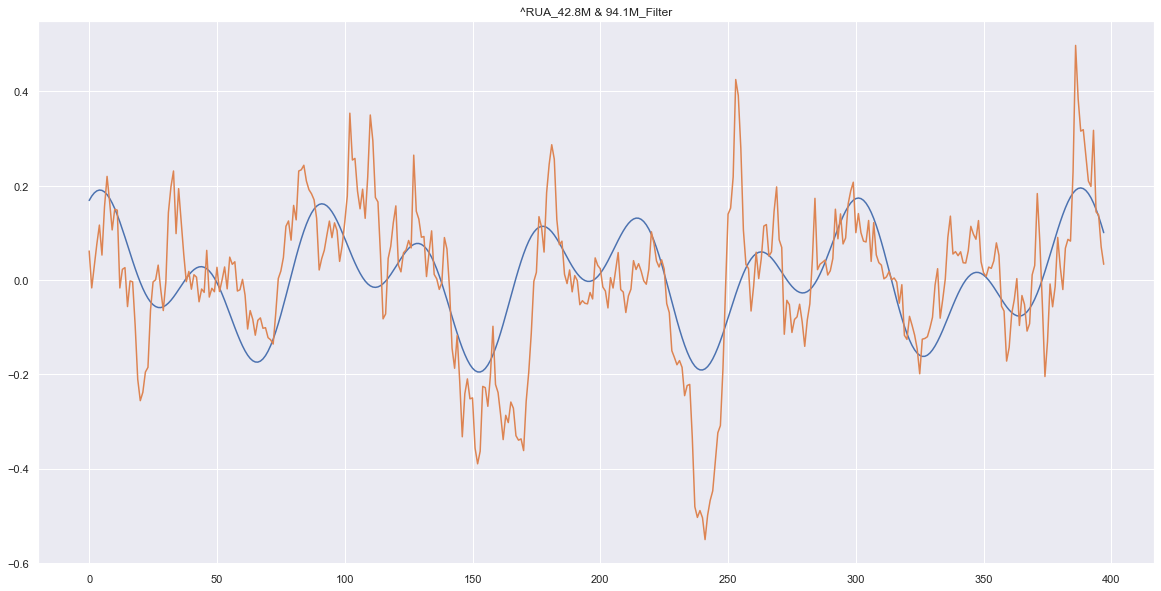

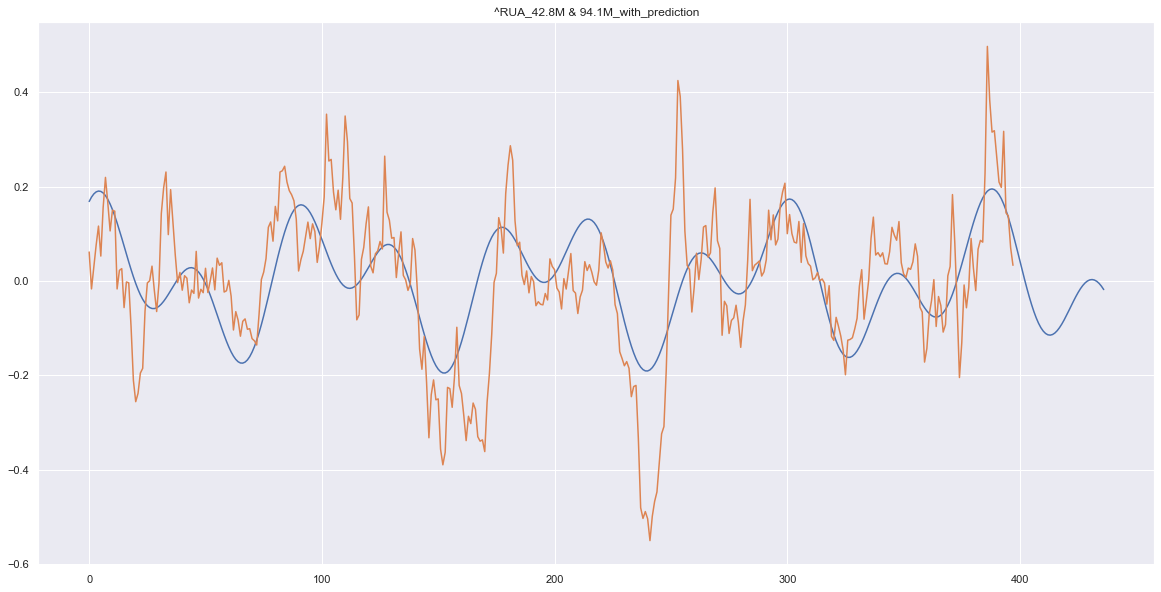

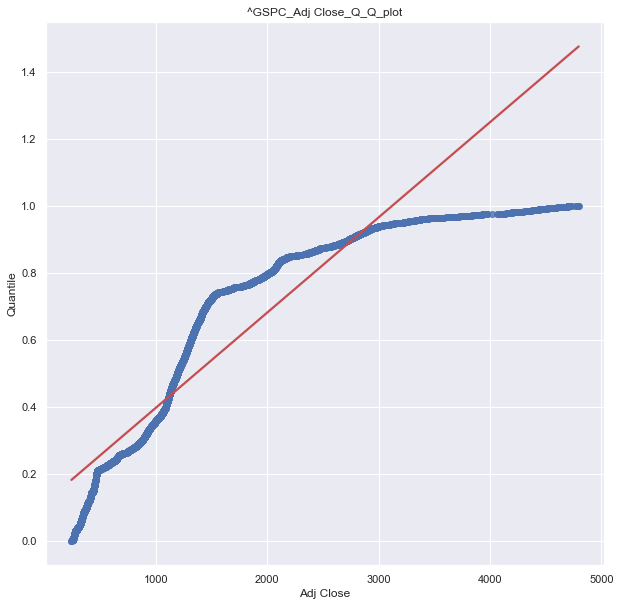

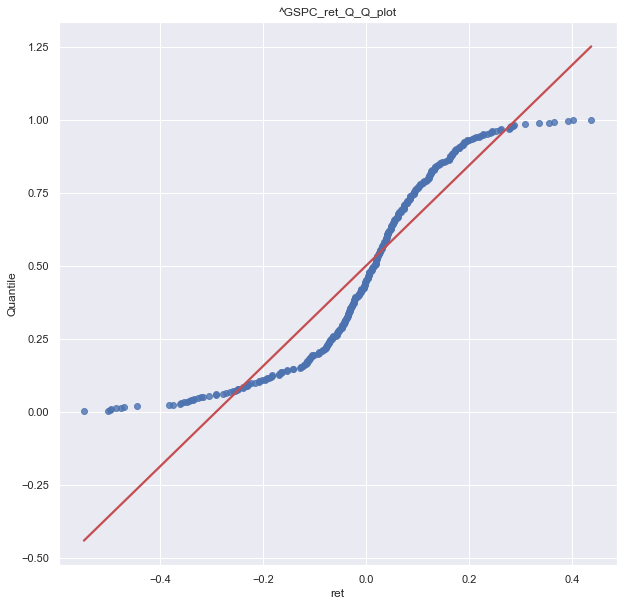

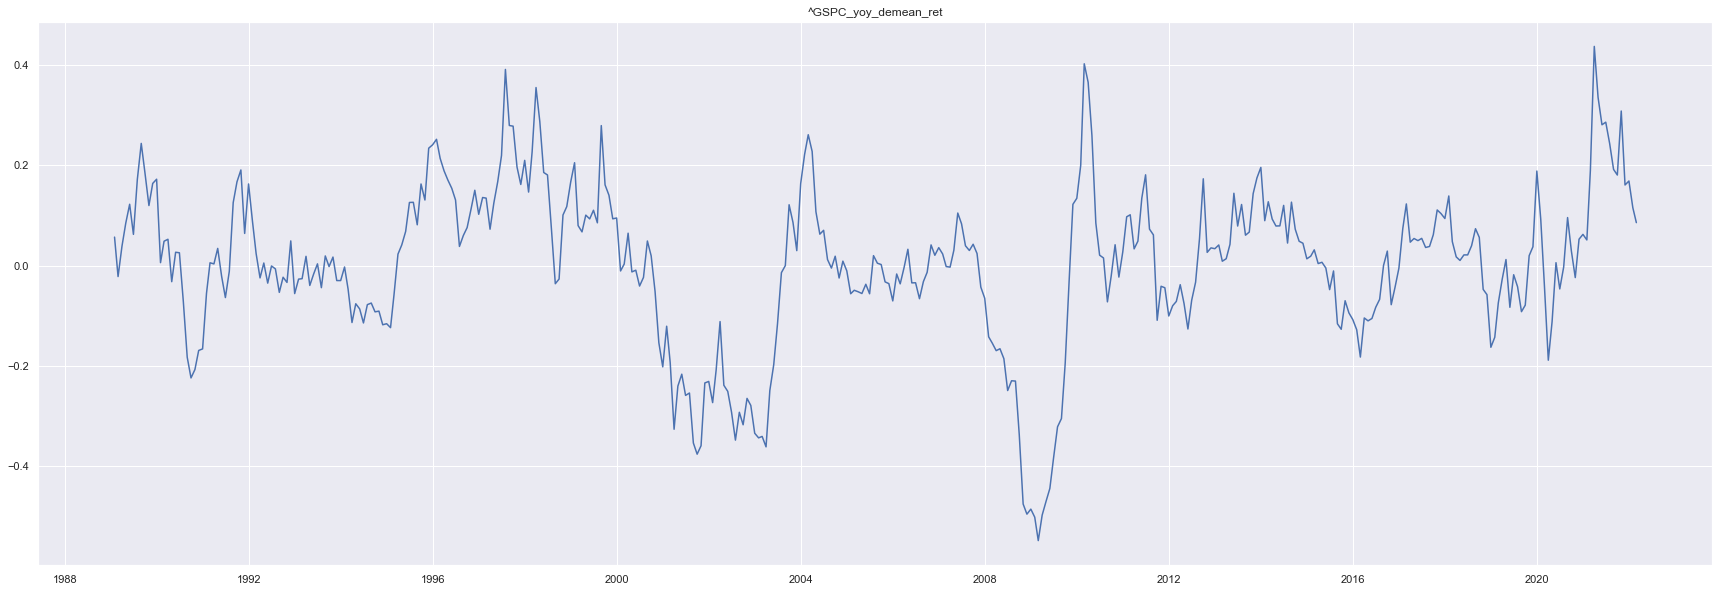

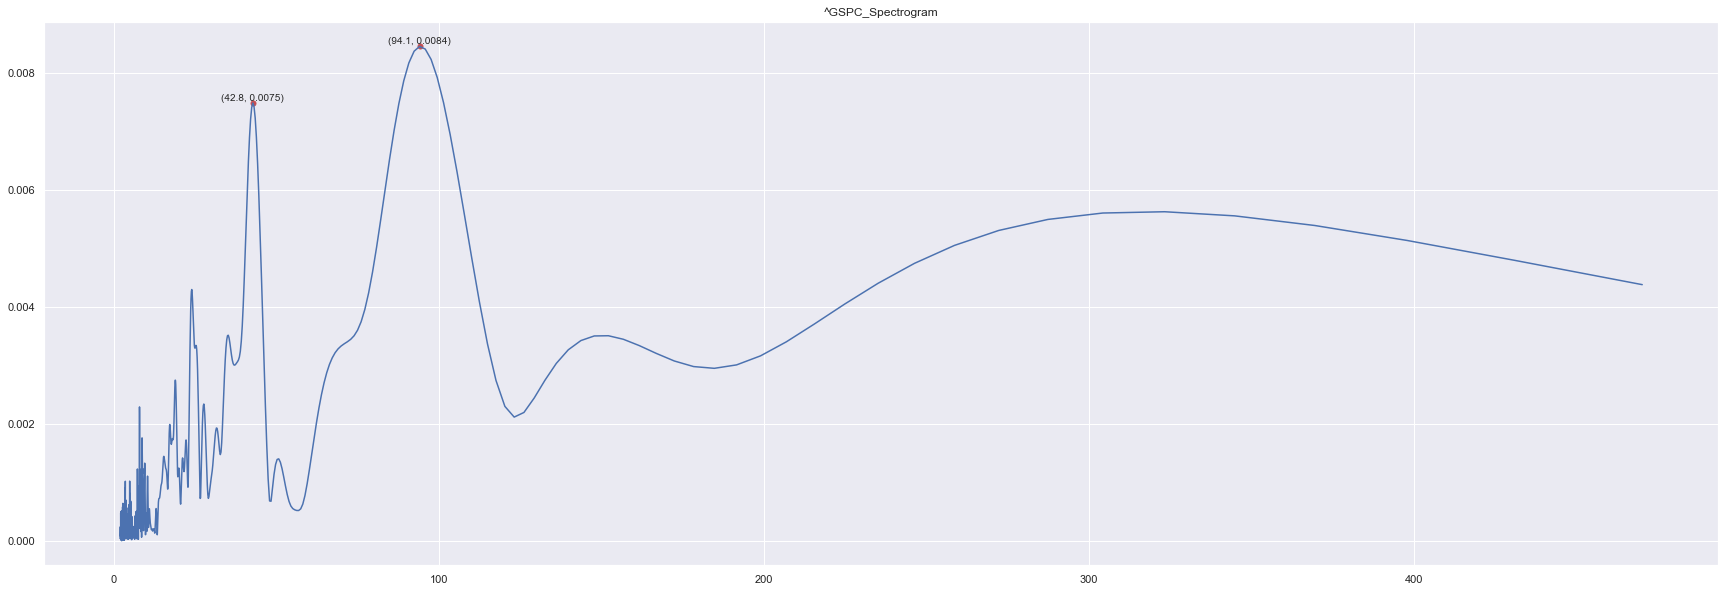

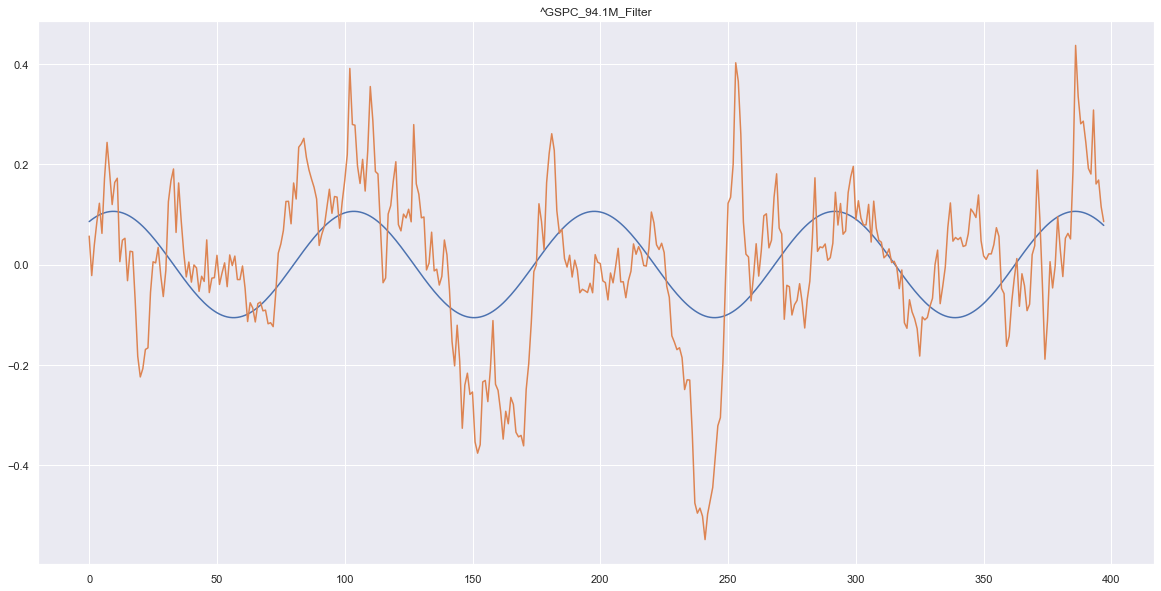

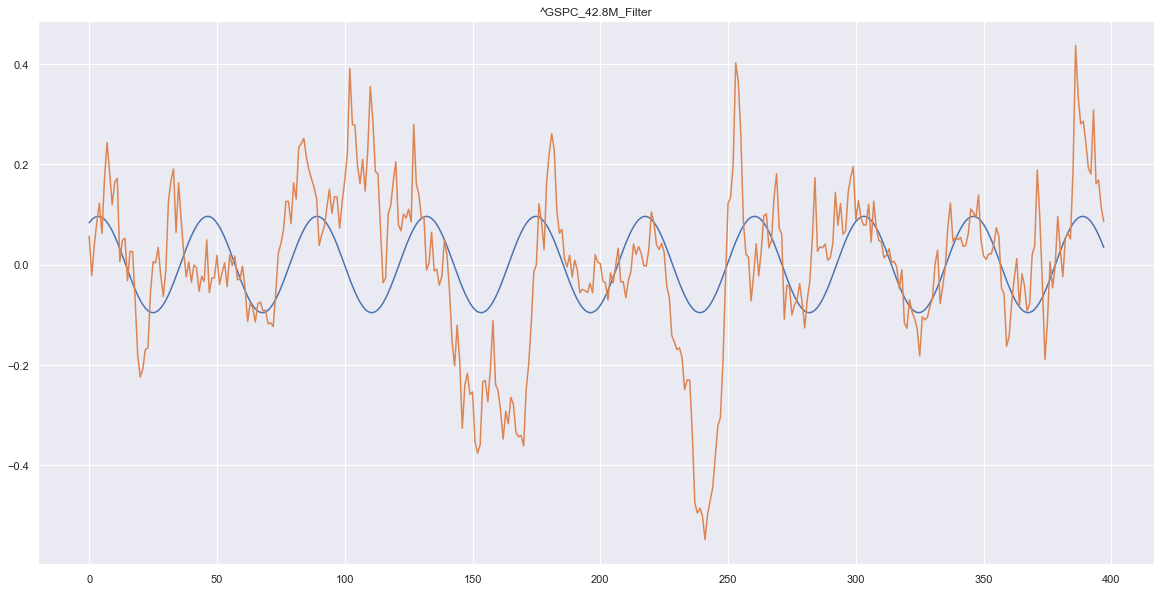

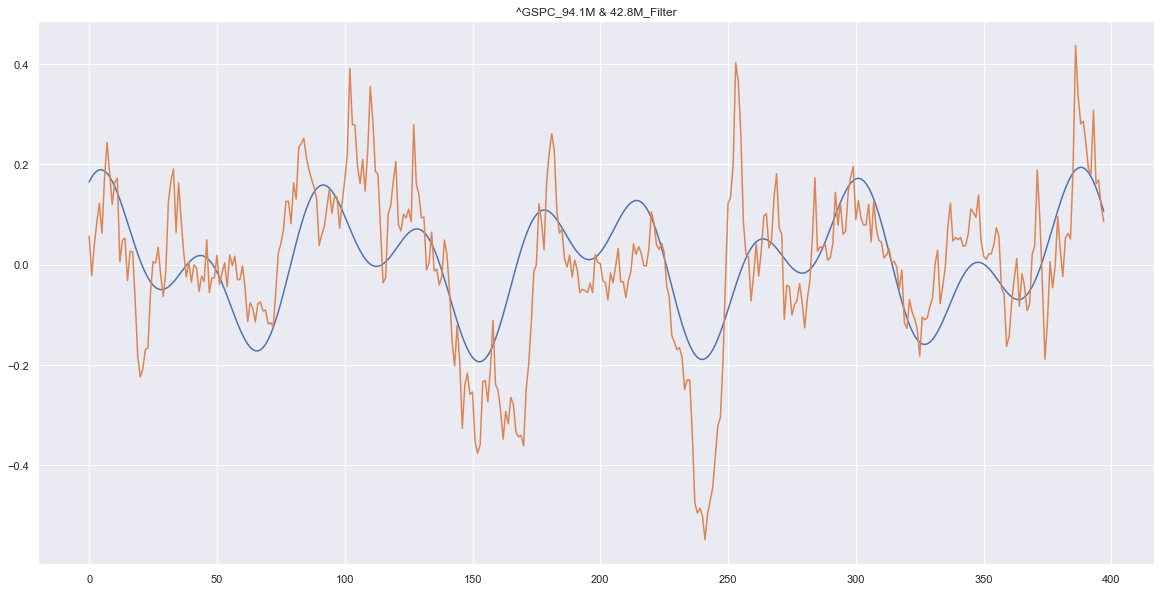

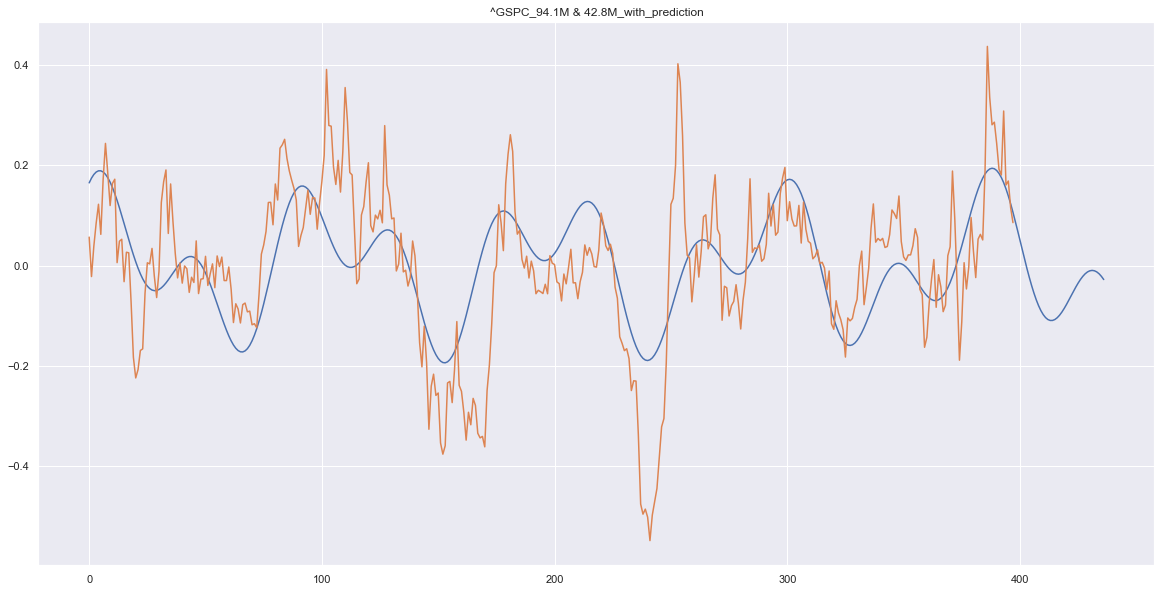

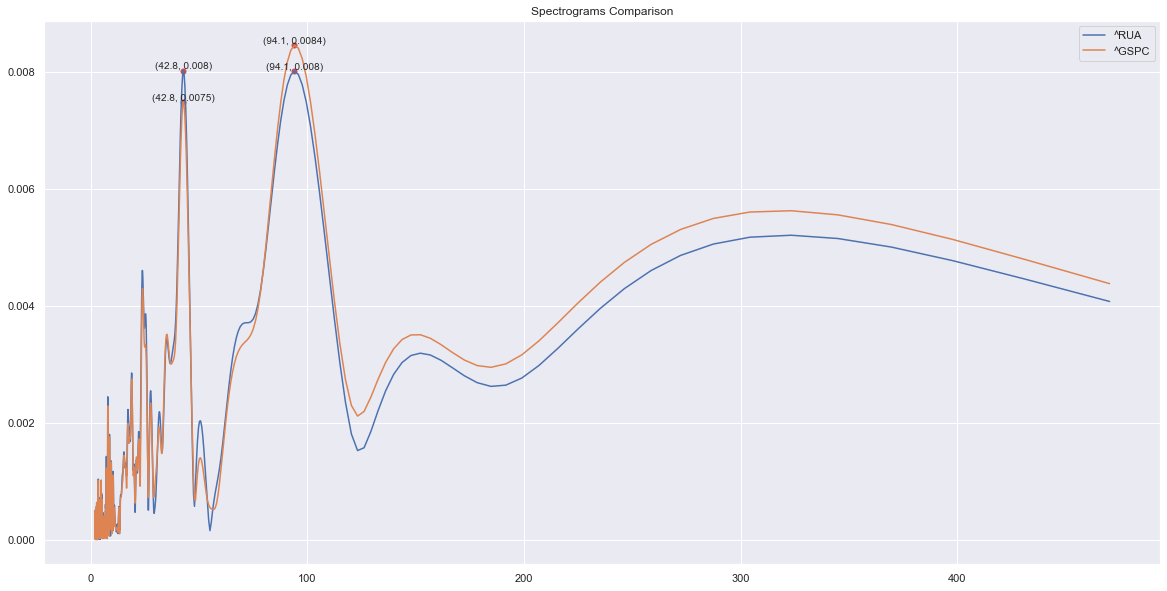

In [4]:
M = Multi_Fourier_Comparison(['^RUA', '^GSPC'])
M._plot()